## References:
- Code source - https://github.com/aivclab/detr/tree/8830cacdc981924169546a0e59d94b6c94fd775d
- Install packages - https://stackoverflow.com/questions/66588715/runtimeerror-cudnn-error-cudnn-status-not-initialized-using-pytorch

## Install packages

In [2]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available(), torch.version.cuda)

1.8.0+cu111 True 11.1


## Params

In [10]:
code_dir = "detr/detr" # folder containing source code for DeTR model
outDir = "detr/weights/exp1" # training outputs will be saved in this folder


"""  Training  """

epochs = 100
batch_size = 20


"""  Model loading  """

pretrained = True # use pre-trained model
pretrained_url = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'
pretrained_download_dir = 'weights/pretrained/detr-r50_no-class-head.pth' # dir to store pre-trained model file


"""  Dataset  """

dataset_file = "coco_custom"
dataDir= "datasets/coco_dataset" # coco dataset folder
num_classes = 2 # actual number of classes + 1 (for no class)
pretrained_file_dir = pretrained_download_dir if pretrained else ""

In [3]:
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/train-ai/code/Users/imaduako/detr/detr


## Change dir

In [4]:
#%cd {code_dir}

[Errno 2] No such file or directory: 'detr/detr'
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ai-model-training/code/Users/imaduako/detr/detr


## Load pre-trained model

This greatly depends on the size of a dataset. Smaller datasets rely more on finetuning. 

In [11]:
if pretrained:
    # Get pretrained weights
    checkpoint = torch.hub.load_state_dict_from_url(
                url = pretrained_url,
                map_location = 'cpu',
                check_hash = True)

    # Remove class weights
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]

    # SaveOGH
    torch.save(checkpoint,
               pretrained_download_dir)

In [7]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-a1tj7bqk
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-a1tj7bqk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=437582 sha256=88614eff2859f11d10a06e7973b0c0c4a0a509c2bd99a6d849d816f01baea666
  Stored in directory: /tmp/pip-ephem-wheel-cache-ut1irpr9/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


## Training

We use the main.py script to run our training

In [12]:
!python main.py \
  --dataset_file {dataset_file} \
  --coco_path {dataDir} \
  --output_dir {outDir} \
  --resume {pretrained_file_dir} \
  --num_classes {num_classes} \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs {epochs} \
  --batch_size {batch_size}

Not using distributed mode
fatal: detected dubious ownership in repository at '/mnt/batch/tasks/shared/LS_root/mounts/clusters/train-ai/code/Users/imaduako/detr/detr'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/train-ai/code/Users/imaduako/detr/detr
git:
  sha: N/A, status: clean, branch: N/A

Namespace(aux_loss=True, backbone='resnet50', batch_size=20, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='datasets/coco_dataset', dataset_file='coco_custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=100, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='detr/weights/exp1', position_embedding='s

In [5]:
import numpy as np
print(np.__version__)


1.20.0


## Results

Quick and easy overview of the training results

In [13]:
from util.plot_utils import plot_logs
from pathlib import Path

In [14]:
log_directory = [Path(outDir)]

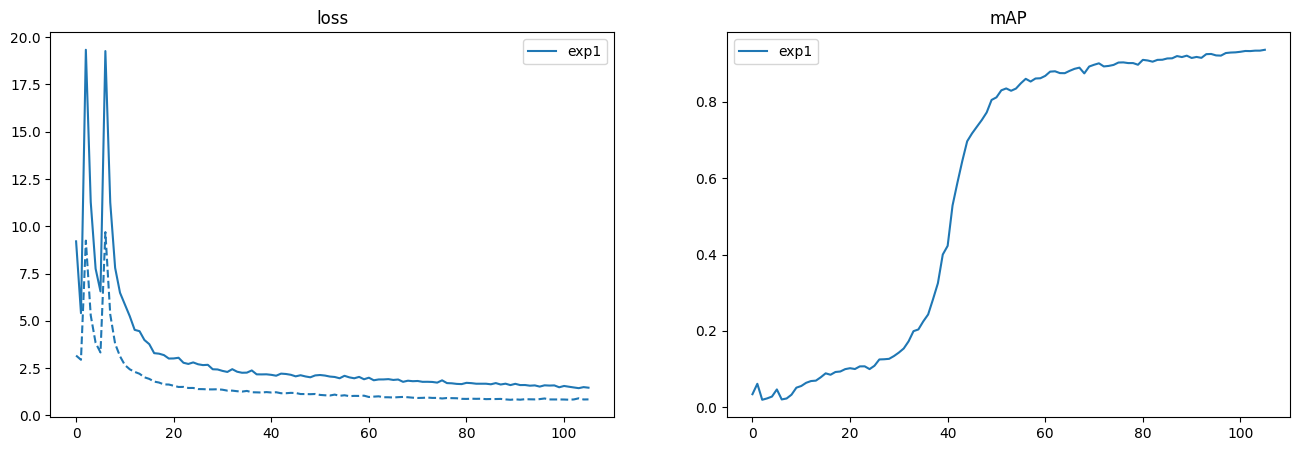

In [15]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

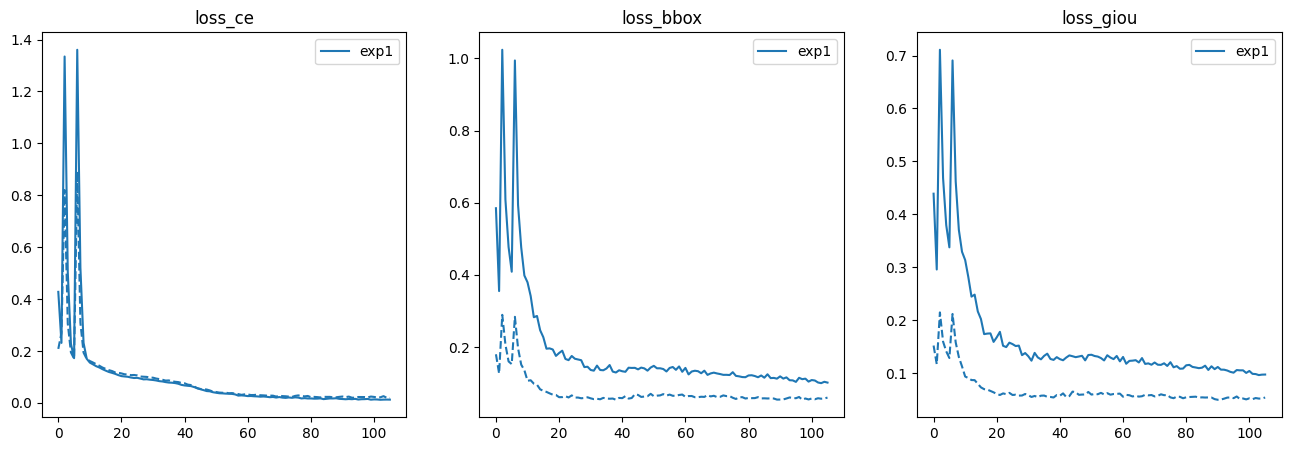

In [16]:
# Visualize 
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

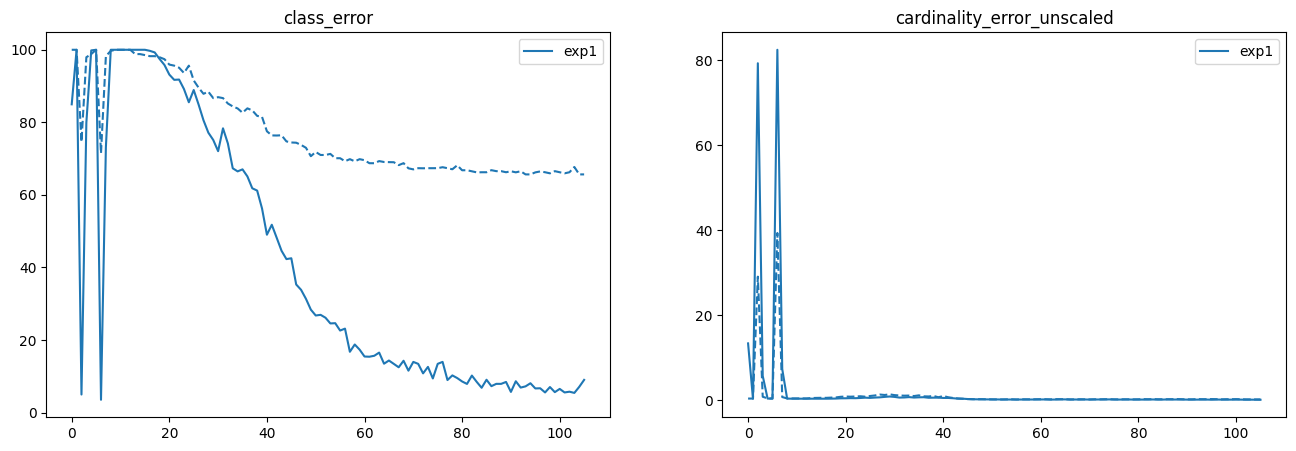

In [17]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

## Prediction on a single image

In [9]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

### Params

In [10]:
conf_threshold = 0.5

# COCO classes
CLASSES = ['N/A', 'school']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Util functions

In [11]:
# util functions for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

### Load trained model

In [12]:
trained_checkpoint_dir = os.path.join(outDir, "checkpoint.pth")

# load checkpoint
checkpoint = torch.load(trained_checkpoint_dir, map_location='cpu')

# load model architecture
model = torch.hub.load('facebookresearch/detr', 
                       'detr_resnet50', 
                       pretrained=False, 
                       num_classes=2)
# load weights
model.load_state_dict(checkpoint['model'], strict=False)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /home/azureuser/.cache/torch/hub/master.zip


<All keys matched successfully>

### Read image and preprocess

In [16]:
# sample test image
test_image_dir = 'test_images/test_1.jpg'

# read image
im = Image.open(test_image_dir)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

In [14]:
# propagate through the model
outputs = model(img)

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-019a0thw/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /tmp/pip-req-build-019a0thw/aten/src/ATen/native/BinaryOps.cpp:467.

### Post-process prediction results and visualize

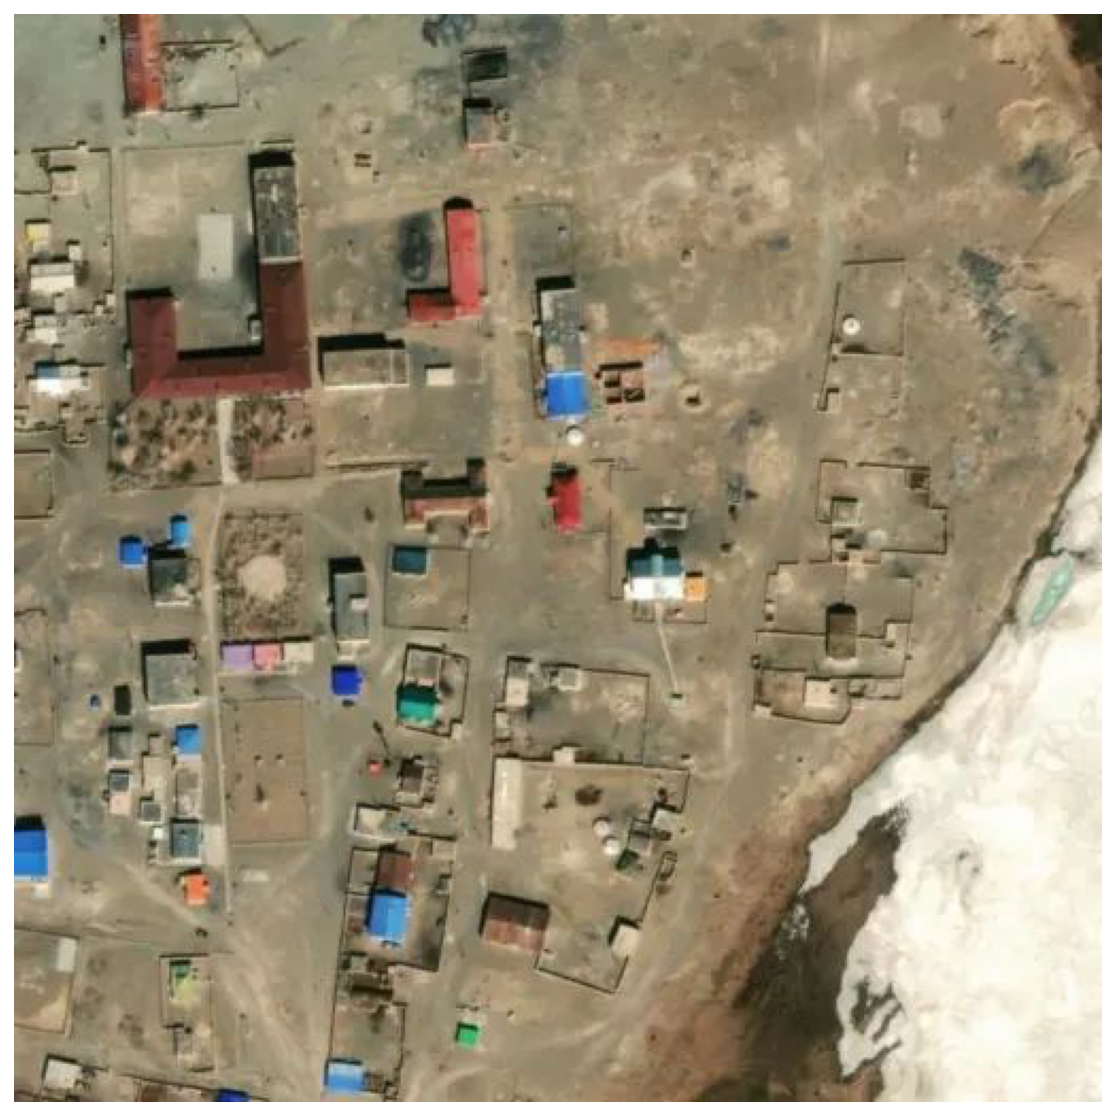

In [15]:
# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > conf_threshold

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)